# Analyse DSM-V disorders based on elements in Ontologies
Described below are the ontologies that I have found online that are related to Psychology and Neuro-psychology, and I am using to check term-frequencies and presence in DSM-V.

Questions that might be interesting to answer:  
- Which disorders are most comorbid? 
- How does the distribution of comorbidity look like in Disorder-Disorder matrix?
- How do you automatically group DSM-V disorders based on ontology terms mentioned?
- How much does each ontology contribute to DSM-V?

### Ontologies 
* [Human Disease Ontology](https://github.com/DiseaseOntology/HumanDiseaseOntology/tree/main/src/ontology)
    - disease of mental health
    - nervous system disease
* [Neurological Disease Ontology](https://github.com/addiehl/neurological-disease-ontology/tree/master/src/ontology)
    - pathological bodily process
    - disease stage
    - disorder
    - neurological disease
    - syndrome
* [Symptom Ontology](https://github.com/DiseaseOntology/SymptomOntology)
    - general symptom
    - neurological and physiological symptom
    - nervous system symptom
    - head and neck symptom
* [MD-core Ontology](https://github.com/jannahastings/mental-functioning-ontology/tree/master/ontology)
    - mental disorder
    - pathological mental process
* [MF-core Ontology](https://github.com/jannahastings/mental-functioning-ontology/tree/master/ontology)
    - bodily disposition
    - interpersonal process
    - mental process
    - consciousness
    - representation

In [12]:
# utils
import numpy as np
import pandas as pd
import seaborn as sns
from itertools import groupby
from examples.utils import (
    generate_test_data,
    open_existing_data,
)
from comorbid_graphs.processable.utils import (
    get_shared_annotations,
    heatmap_plot_df,
    pivot_group,
)
from comorbid_graphs import ComorbidGraph, ComorbidGraphNode

## LOAD DSM-V
This information has been processed with a pre-processing step before of extraction from the pdf. Will be public soon.  

In [2]:
cg = open_existing_data('dsm_v.json')
cg.print_head(maxlevel=4, top=10)

dsm-v
├── Neurodevelopmental Disorders
│   ├── Intellectual Disabilities
│   │   ├── Intellectual Disability 
│   │   ├── Global Developmental Delay
│   │   └── Unspecified Intellectual Disabilit (Intellectual Developmental Disorder)
│   ├── Communication Disorders
│   │   ├── Language Disorder
│   │   ├── Speech Sound Disorder
│   │   ├── Childhood-Onset Fluency Disorder (Stuttering)
│   │   ├── Social (Pragmatic) Communication Disorder
...



In [3]:
# advanced search
# filter all the disorders (type:default) in the tree that are not empty
# check how many of them are there
query_str = """
inc_text_longer:0
inc_ancestor:dsm-v
"""
result_cg = cg.advanced_search(query_str)
result_cg.print_head(maxlevel=3, top=10)

Merged results
├── Autism Spectrum Disorder Autism Spectrum Disorder
│   ├── Diagnostic Criteria
│   ├── Recording Procedures
│   ├── Specifiers
│   ├── Diagnostic Features
│   ├── Associated Features Supporting Diagnosis
│   ├── Prevalence
│   ├── Development and Course
│   ├── Risk and Prognostic Factors
│   ├── Culture-Related Diagnostic Issues
...



## Comorbidity: Disorder vs Disorder comparison
The all time question: Matrix of comorbidity.

In [4]:
# sections included in the analysis
sections = {
    'Diagnostic Criteria', 'Specifiers', 'Diagnostic Features',
    'Associated Features Supporting Diagnosis', 'Prevalence',
    'Development and Course', 'Risk and Prognostic Factors',
    'Culture-Related Diagnostic Issues', 'Gender-Related Diagnostic Issues',
    'Differential Diagnosis', 'Comorbidity',
    'Relationship to Other Classifications', 'Functional Consequences of',
    'Recording Procedures', 'ND_0003015'
}

In [5]:
disorder_annotations = {
    i.name: set([j['name'] for j in i.annotation_list]) 
    for i in result_cg.get_nodes(exclude_head=True)
    if i.type == 'default'
}

data = []
for disorder, annontations in disorder_annotations.items():
    data.append({
        "disorder": disorder,
        **{
            dis: set.intersection(annontations, anns) - sections
            for dis, anns in disorder_annotations.items()
        },
        disorder: set(),
    })

processed_df = (
    pd.DataFrame(data)
    .replace({np.nan: set()})
    .set_index('disorder')
)
# processed_df.tail(5)

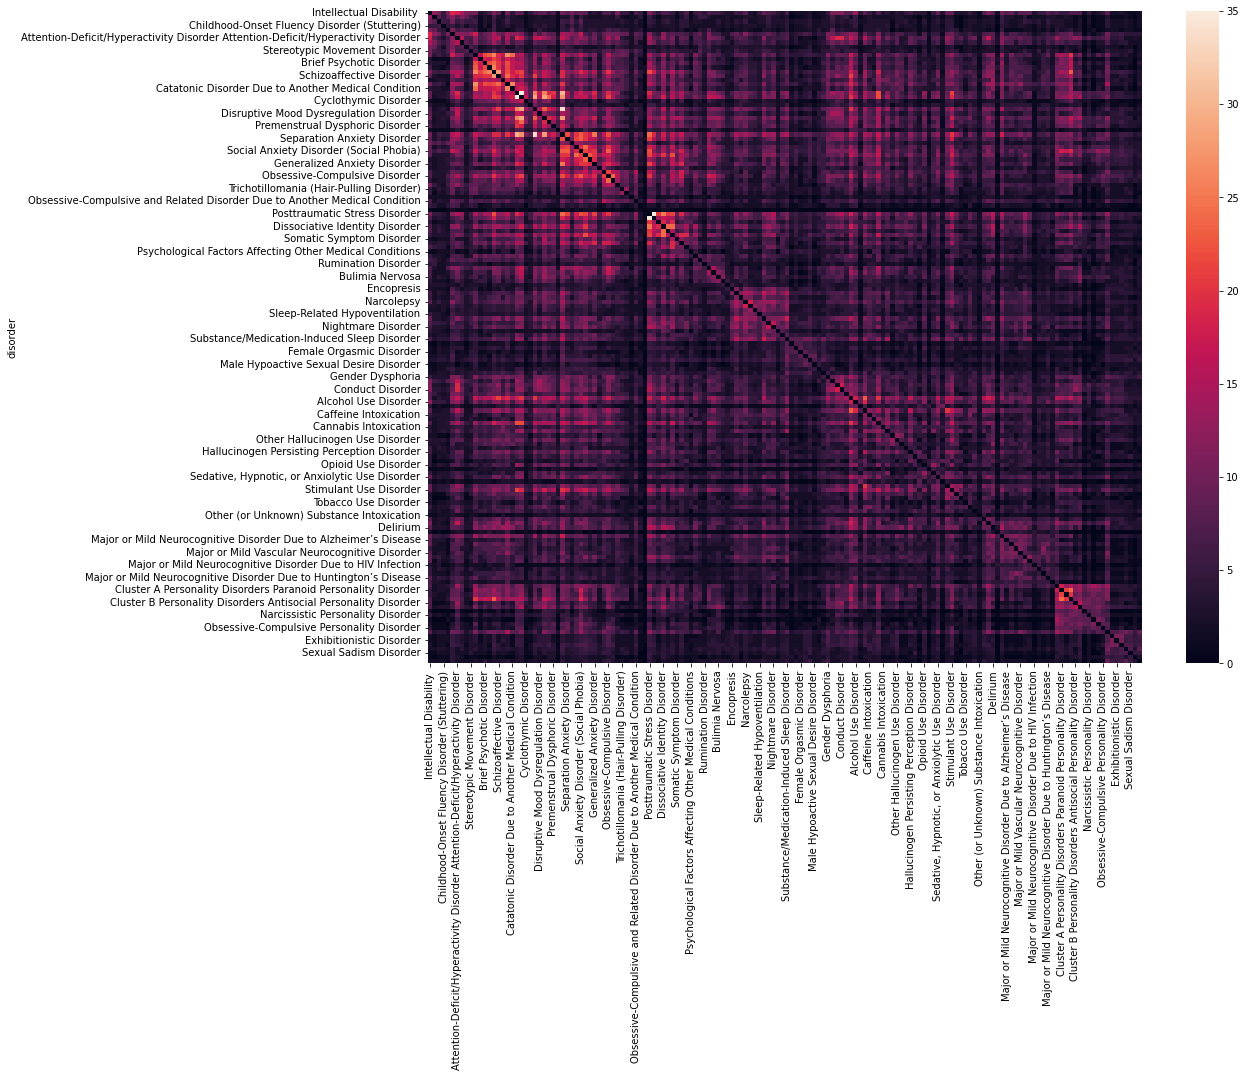

In [6]:
# plot by ordering based on how many different annotations each disease has
# show top 20
heatmap_plot_df(
    processed_df
    .applymap(len)
)

## Annotations Distribution in Sections of Disorders

In [7]:
# filter only the sections in the tree
node_list = [
    i for i in result_cg.get_nodes(exclude_head=True) 
    if i.type == 'default' # and i.old_parent and i.old_parent.name == 'Communication Disorders'
]

# check comorbid_graph.processable.label_handler_mixin
processed_df = result_cg.compare_section_annotations(node_list, include_stats=True)

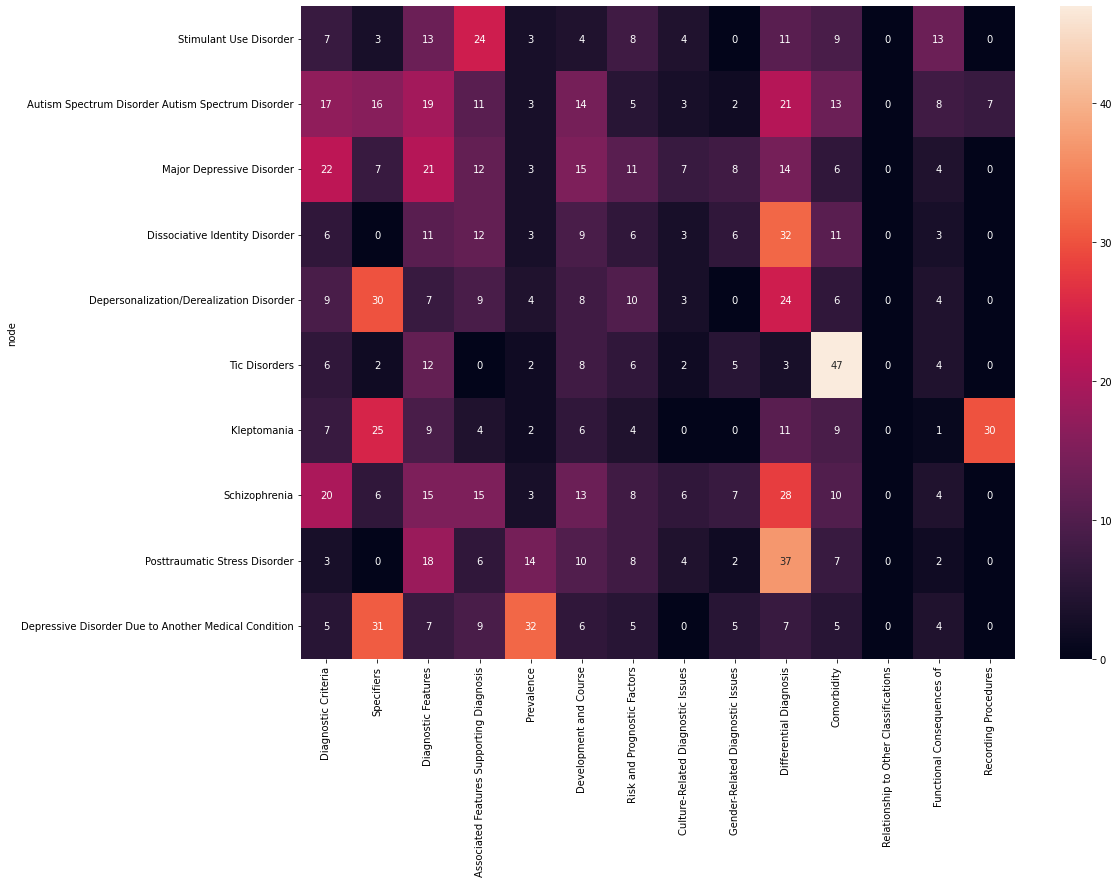

In [8]:
# plot by ordering based on how many different annotations each disease has
# show top 10
heatmap_plot_df(
    processed_df
    .applymap(len)
    .sort_values('all')
    .iloc[1:-1,:-2]
    .tail(10),
    annot=True
)

### How to automatically group disorders based on terms mentioned?
Here is a simple z-score usage, and a basic grouping of disorders. Meaningless for now, but will eventually be a good description of DSM-V to see how much the existing classification fits with an automatic one. 

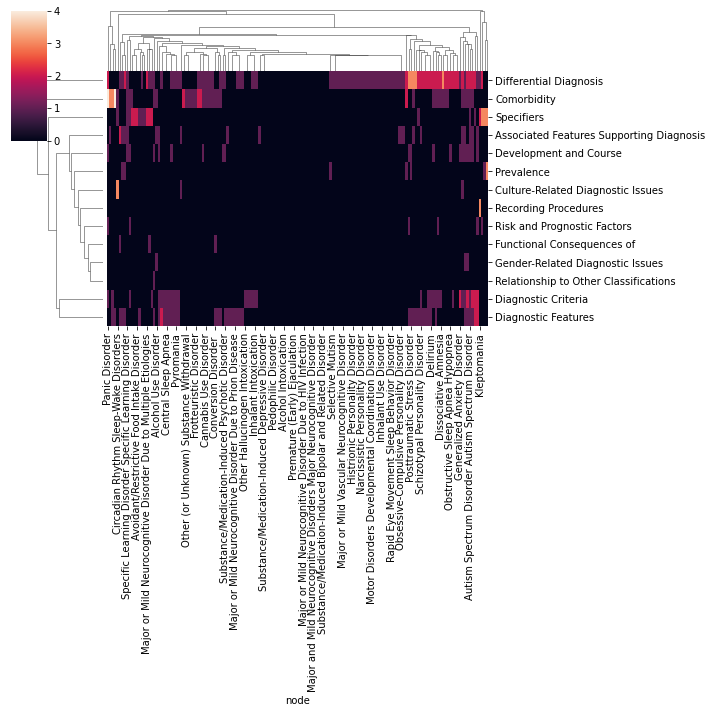

In [9]:
g = sns.clustermap(
    processed_df
    .applymap(len)
    .applymap(lambda x: int(x/10))
    .sort_values('all')
    .iloc[1:-1,:-2].T
)

## How much does each Ontology contribute DSM-V annotations?
Based on the existing ontologies that can be found at [Garden of Graphs: Tools](http://garden-of-graphs.herokuapp.com/annotations), how much is each disorder mentioning terms of the ontologies. 

In [10]:
# get all non-empty disorders
node_list = [
    i for i in cg.get_nodes()
    if i.annotation_list != [] and not(i.type and i.type == 'section')
]

# create a row for each disorder:
# Disorder-Name, Ontology-Set elements, Ontology2-Set2 elements, ...
data = []
for i in node_list:
    data.append(
        {
            "disorder":i.name,
            **pivot_group(i.annotation_list, 'ancestor'),
        }
    )
processed_df = get_shared_annotations(
    pd.DataFrame(data)
    .set_index('disorder')
    .replace({np.nan: set()})
)
processed_df.tail(5)

,dsm_v,disease stage_ND,syndrome_ND,mental process_MF-core,bodily disposition_MF-core,interpersonal process_MF-core,disease of mental health_HumanDO,general symptom_symp,nervous system symptom_symp,pathological mental process_MD-core,disorder_ND,nervous system disease_HumanDO,pathological bodily process_ND,neurological disease_ND,head and neck symptom_symp,neurological and physiological symptom_symp,mental disorder_MD-core,all,common
Sexual Sadism Disorder,"{Paraphilic Disorders, Pedophilic Disorder, Se...",{onset},{ND_0003015},{arousal},{},{},{sexual sadism},{},{pain},{orientation},{},{},{},{},{},{anxiety},{},"{ND_0003015, Sexual Sadism Disorder, arousal, ...",{}
Pedophilic Disorder,"{Fetishistic Disorder, Pedophilic Disorder}",{},{ND_0003015},"{orgasm, arousal}",{preference},{},{personality disorder},{},{},{orientation},{},{},{},{},{},{anxiety},{},"{ND_0003015, preference, arousal, personality ...",{}
Fetishistic Disorder,{Transvestic Disorder},{onset},{ND_0003015},{smelling},{preference},{},{tic disorder},{},{},{},{},{},{},{},{},{},{},"{ND_0003015, smelling, onset, preference, tic ...",{}
all,"{Speech Sound Disorder, Cluster A Personality ...","{relapse, remission, asymptomatic, onset, acut...","{ND_0003015, dementia, epilepsy}","{touching, hearing, smelling, planning, vigila...","{personality, preference, neuroticism, retenti...","{attachment, communication}","{post-traumatic stress disorder, intellectual ...","{weakness, inflammation, insomnia, hypersomnia...","{paralysis, hemiparesis, abdominal pain, convu...","{regression, binge eating, delusion, manic epi...","{injury, genetic disorder, neoplasm, transient...","{migraine, neuropathy, lateral sclerosis, hepa...","{seizure, neurodegeneration}","{neurodegenerative disease, multiple sclerosis...","{mouth sore, dysphagia, dry mouth, slurred spe...","{catatonia, hyperpyrexia, coma, dizziness, anx...","{sexual disorder, alcohol abuse, sex addiction...","{Speech Sound Disorder, post-traumatic stress ...",{}
common,{},{},{ND_0003015},{},{},{},{},{},{},{},{},{},{},{},{},{},{},{ND_0003015},{}


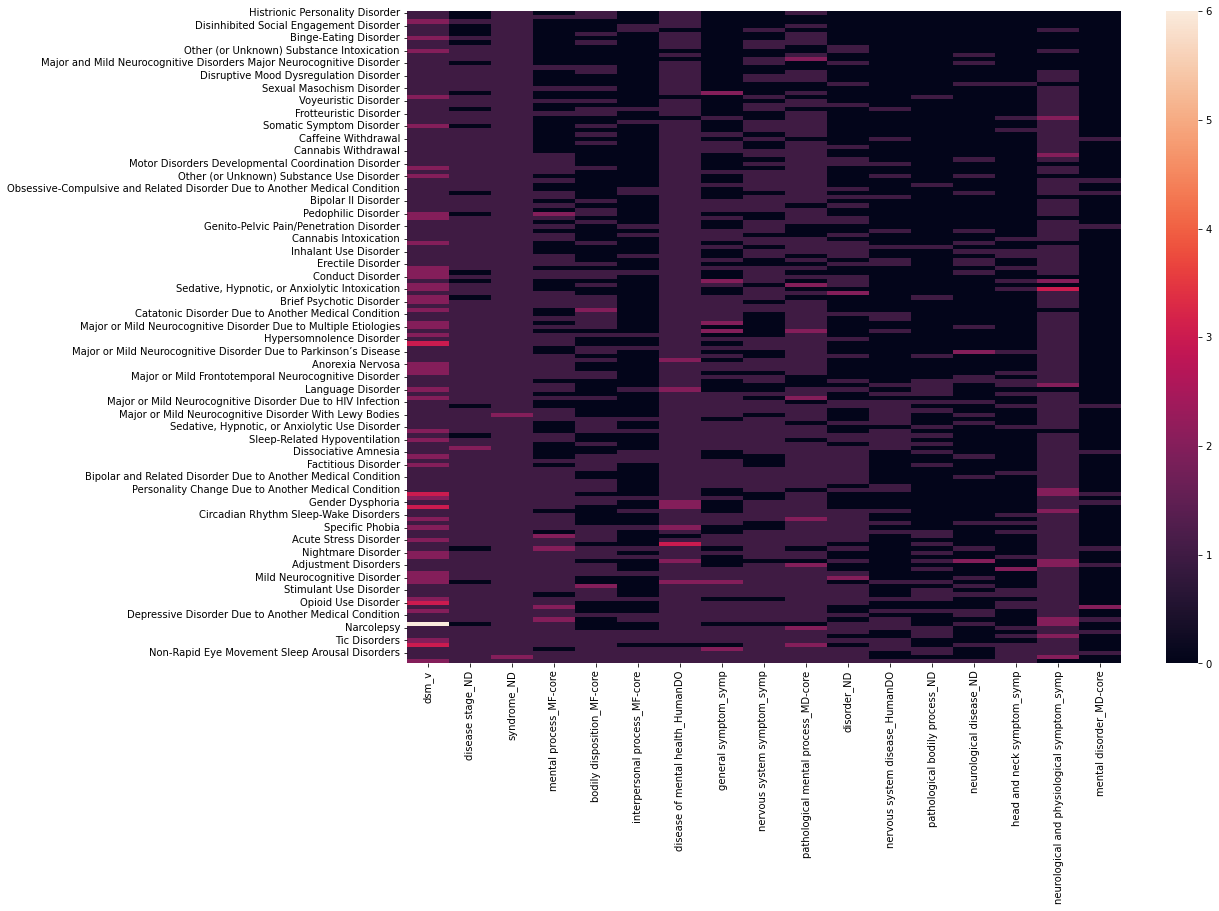

In [11]:
heatmap_plot_df(
    processed_df.applymap(len)
    .sort_values(['all'])
    .iloc[1:-1,0:-2] # skip total, common, all
)

## Conclusion
* [ToDo]()

## References
* [Comorbid Graphs]()
* [DSM-V]()